# Anticipez les besoins en consommation électrique de bâtiments


Etude data - Projet 4 - Nalron (Novembre 2020) OpenClassrooms / CentraleSupélec

Traitement des données sur Jupyter Notebook (Distribution Anaconda)

Etude réalisée en langage Python

*Data source* : [Kaggle City of Seattle ](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv) - [Open Data Seattle](https://data.seattle.gov/)

---

# Modèles de prédiction
## Bref rappel de la problématique de la ville de Seattle
Des relevés minutieux ont été effectués par nos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous souhaitons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

On cherchera également à évaluer l’intérêt de l’"[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par notre équipe.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.options.display.max_columns = 100
plt.style.use('ggplot') 
plt.rcParams.update(
    {
     'figure.figsize': (15, 10),
     'axes.labelsize': 15,
     'axes.titlesize':25,
     'xtick.labelsize':10,
     'ytick.labelsize':10,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [3]:
#Loading dataframe from the last Notebook
df = pd.read_csv('p4_00_data/df.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,ENERGYSTARScore,LargestPropertyUseType,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofFloors,NumberofBuildings,PrimaryPropertyType,Longitude,Latitude,BuildingType,DataYear,CouncilDistrictCode,Neighborhood,YearBuilt,PropertyGFATotal,SiteEnergyUse(kBtu)_trans,TotalGHGEmissions_trans
0,65.0,Hotel,249.43,6981428.0,12.0,1.0,Hotel,-122.337997,47.612190,NonResidential,2015,7,DOWNTOWN,1927,88434,1.070310,1.335240
1,51.0,Hotel,263.51,8354235.0,11.0,1.0,Hotel,-122.333358,47.613106,NonResidential,2015,7,DOWNTOWN,1996,103566,1.199589,1.367664
2,18.0,Hotel,2061.48,73130656.0,41.0,1.0,Hotel,-122.337699,47.613349,NonResidential,2015,7,DOWNTOWN,1969,961990,2.469797,2.502523


In [4]:
df.shape

(6300, 17)

In [5]:
df.describe()

,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofFloors,NumberofBuildings,Longitude,Latitude,DataYear,CouncilDistrictCode,YearBuilt,PropertyGFATotal,SiteEnergyUse(kBtu)_trans,TotalGHGEmissions_trans
count,6300.000000,6300.000000,6.300000e+03,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6.300000e+03,6300.000000,6300.000000
mean,66.843365,114.938441,5.227843e+06,4.741270,1.071905,-122.335062,47.624545,2015.506825,4.461746,1968.362222,9.340895e+04,-0.001384,-0.000204
std,24.796450,488.557743,1.857569e+07,5.541717,1.636057,0.026860,0.047562,0.499993,2.118710,32.994545,1.913907e+05,0.996682,0.997034
min,1.000000,0.080000,1.144100e+04,0.000000,0.000000,-122.414250,47.500557,2015.000000,1.000000,1900.000000,1.128500e+04,-7.822055,-4.916797
25%,52.000000,9.555000,9.304217e+05,2.000000,1.000000,-122.350706,47.600495,2015.000000,3.000000,1948.000000,2.832800e+04,-0.711246,-0.814263
50%,72.000000,33.110000,1.784591e+06,4.000000,1.000000,-122.332634,47.618963,2016.000000,4.000000,1975.000000,4.382250e+04,-0.062780,0.058805
75%,87.000000,90.155000,4.120209e+06,5.000000,1.000000,-122.319864,47.657301,2016.000000,7.000000,1997.000000,8.954900e+04,0.665208,0.712927
max,100.000000,16870.980000,8.739237e+08,99.000000,111.000000,-122.220470,47.733870,2016.000000,7.000000,2015.000000,9.320156e+06,3.423598,3.515597


In [6]:
df.select_dtypes(include='object').columns

Index(['LargestPropertyUseType', 'PrimaryPropertyType', 'BuildingType',
       'Neighborhood'],
      dtype='object')

## Modèles de prédiction et tests de performance
L'objectif ici est de tester différents modèles de prédiction afin de répondre au mieux à la problématique.

In [7]:
for var in df.select_dtypes(include='object').columns : 
    display(df[var].value_counts())

Multifamily Housing                                     3172
Office                                                   940
Non-Refrigerated Warehouse                               390
Other                                                    200
Retail Store                                             187
K-12 School                                              180
Hotel                                                    142
Worship Facility                                         139
Distribution Center                                      106
Senior Care Community                                     87
Medical Office                                            82
Supermarket/Grocery Store                                 77
Parking                                                   60
Self-Storage Facility                                     55
Other - Recreation                                        50
College/University                                        46
Other - Entertainment/Pu

Low-Rise Multifamily           1869
Mid-Rise Multifamily           1056
Small- and Mid-Sized Office     556
Other                           500
Large Office                    323
Mixed Use Property              253
High-Rise Multifamily           195
Warehouse                       185
Non-Refrigerated Warehouse      181
K-12 School                     180
Retail Store                    170
Hotel                           140
Worship Facility                139
Senior Care Community            85
Medical Office                   78
Distribution Center              53
Distribution Center\n            51
Supermarket / Grocery Store      39
Supermarket/Grocery Store        35
Self-Storage Facility            27
Self-Storage Facility\n          27
University                       25
Refrigerated Warehouse           24
Residence Hall                   23
College/University               21
Hospital                         19
Residence Hall/Dormitory         15
Restaurant                  

NonResidential          2790
Multifamily LR (1-4)    1927
Multifamily MR (5-9)    1088
Multifamily HR (10+)     204
Nonresidential COS       146
SPS-District K-12         99
Campus                    45
Nonresidential WA          1
Name: BuildingType, dtype: int64

DOWNTOWN                  1071
EAST                       859
MAGNOLIA / QUEEN ANNE      806
GREATER DUWAMISH           703
NORTHEAST                  506
LAKE UNION                 468
NORTHWEST                  410
NORTH                      316
SOUTHWEST                  298
BALLARD                    242
CENTRAL                    215
SOUTHEAST                  166
DELRIDGE                   153
North                       40
Central                     26
Northwest                   10
Ballard                      6
Delridge                     4
DELRIDGE NEIGHBORHOODS       1
Name: Neighborhood, dtype: int64

**Rappelons que toutes les modalités ne sont pas représentatives.**\
La solution peut-être de catégoriser ces modalités dans une catégorie à part entière "Others". Un seuil limite d'effectifs fixé à 100 par observation semble raisonnable, prenons ce seuil de référence pour différencier les observations les plus représentatives de celles moins significatives.

Le traitement des variables catégorielles sera fait par encodage OneHot, ce traitement des modalités considérées comme étant les plus faibles, aura pour avantage de limiter le nombre de catégories implémentées par l'encodage.

In [8]:
def run_var(data, count_nbre):
    '''enumeration and selection of the population according to a threshold'''
    categorical_columns = data.select_dtypes(['object']).columns
    for var in categorical_columns:
        count = data[var].value_counts()
        idx = count[count < count_nbre].index
        data.loc[data[var].isin(idx), var] = 'Others'
        data.reset_index(drop='all', inplace=True)
        
    return data

In [9]:
sample = df.copy()
sample = run_var(df, 100)
sample.shape

(6300, 17)

In [10]:
sample.head(3)

,ENERGYSTARScore,LargestPropertyUseType,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofFloors,NumberofBuildings,PrimaryPropertyType,Longitude,Latitude,BuildingType,DataYear,CouncilDistrictCode,Neighborhood,YearBuilt,PropertyGFATotal,SiteEnergyUse(kBtu)_trans,TotalGHGEmissions_trans
0,65.0,Hotel,249.43,6981428.0,12.0,1.0,Hotel,-122.337997,47.612190,NonResidential,2015,7,DOWNTOWN,1927,88434,1.070310,1.335240
1,51.0,Hotel,263.51,8354235.0,11.0,1.0,Hotel,-122.333358,47.613106,NonResidential,2015,7,DOWNTOWN,1996,103566,1.199589,1.367664
2,18.0,Hotel,2061.48,73130656.0,41.0,1.0,Hotel,-122.337699,47.613349,NonResidential,2015,7,DOWNTOWN,1969,961990,2.469797,2.502523


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)

mymodels = [LinearRegression(), 
          Ridge(), 
          Lasso(),
          ElasticNet(),
          KNeighborsRegressor(),
          SVR(),
          RandomForestRegressor(),
          GradientBoostingRegressor()]

In [12]:
lr_params = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}

ridge_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

lasso_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

elastic_params = {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}

knn_params = {'n_neighbors': list(range(1,30))}

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}

rfr_params = {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}

gradboost_params = {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]}


mygrids = [lr_params, ridge_params, lasso_params, elastic_params, knn_params, svr_params, 
         rfr_params, gradboost_params ]

In [13]:
def data_preprocessing(data, target, exclude, test_size):
    '''Standardize, encode and split data'''
    
    X = data.drop(exclude, axis=1)
    y = data[target]

    categorical_columns = X.select_dtypes(['object']).columns
    numerical_columns =  X.select_dtypes(['int64','float64']).columns

    scaler = StandardScaler()
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

    encoder = OneHotEncoder(sparse=False)
    X_categorical = encoder.fit_transform(X[categorical_columns])

    X = pd.merge(X[numerical_columns], 
                pd.DataFrame(columns = encoder.get_feature_names().tolist(), data = X_categorical),
                left_index = True, right_index = True)
    
    X.drop(X.filter(regex='_Other*').columns, axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)


    return X_train, X_test, y_train, y_test

In [14]:
def regressor_compar(data, models, grids, foldername):
    '''Modeling of our algorithms with performance summary table.
       Save templates for easy use…'''
    
    print('Comparative table of models…') 
 
    cols = ['lr', 'ridge', 'lasso', 'elastic', 'knn', 'svr', 'rfr', 'gradboost']
    index = ['Standard Time', 'GridSearch Time', 'RandomSearch Time', 
             'Standard R²', 'GridSearch R²', 'RandomSearch R²',
             'Standard RMSE', 'GridSearch RMSE', 'RandomSearch RMSE']
    results = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    start_time = time.time()
    for model in models:
        model_fit = model.fit(X_train, y_train)       

        #filename = str(model_fit).split('(')[0]
        #pickle.dump(model_fit, open(foldername + str(filename + '_standard') + '.pkl', 'wb'))
        results.iloc[0,col] = time.time() - start_time
        results.iloc[3,col] = r2_score(y_test, model_fit.predict(X_test))
        results.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_fit.predict(X_test)))

        filename = str(model_fit).split('(')[0]
        pickle.dump(model_fit, open(foldername + str(filename + '_gridsearch') + '.pkl', 'wb'))
        grid_search = GridSearchCV(estimator=models[col], param_grid=grids[col], n_jobs=-1, cv=5)
        grid_acc = grid_search.fit(X_train, y_train)
        results.iloc[1,col] = time.time() - start_time
        results.iloc[4,col] = r2_score(y_test, grid_acc.predict(X_test))
        results.iloc[7,col] = np.sqrt(mean_squared_error(y_test, grid_acc.predict(X_test)))

        #filename = str(model_fit).split('(')[0]
        #pickle.dump(model_fit, open(foldername + str(filename + '_randomsearch') + '.pkl', 'wb'))
        random_search = RandomizedSearchCV(models[col],
        param_distributions=grids[col],n_iter=3, cv=5, iid=False)
        random_acc = random_search.fit(X_train, y_train)
        results.iloc[2,col] = time.time() - start_time
        results.iloc[5,col] = r2_score(y_test, random_acc.predict(X_test))
        results.iloc[8,col] = np.sqrt(mean_squared_error(y_test, random_acc.predict(X_test)))
        col += 1

    return results

In [15]:
def regression_visualizers(get_model, get_folder):
    '''Visualization by histogram, scatterplot, QQ-plot
        errors and actual values vs prediction.'''

    model = pickle.load(open(get_folder + '/' + get_model + '.pkl', 'rb'))
    y_pred = model.predict(X_test)
    error = y_pred - y_test

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    sns.scatterplot(x=error, y=y_pred , color='slateblue')
    plt.axhline(0, color='red', linestyle='dashed')
    plt.title("error vs prediction")
    plt.xlabel('')

    plt.subplot(222)
    sns.scatterplot(x=y_test, y=y_pred, color='slateblue')
    plt.title("real vs prediction")
    plt.xlabel('')

    plt.subplot(223)
    sns.distplot(error, kde=True, color='slateblue')
    plt.title("error distribution")
    plt.xlabel('')

    plt.subplot(224)
    stats.probplot(y_pred, plot=sns.mpl.pyplot)
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

## Recherche de modèles de prédiction pour la consommation totale d’énergie
Rappelons que l'objectif est de pouvoir faire des prévisions sur la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

In [16]:
X_train, X_test, y_train, y_test = data_preprocessing(data=sample, target='SiteEnergyUse(kBtu)_trans', 
                                   exclude=['SiteEnergyUse(kBtu)_trans', 'SiteEnergyUse(kBtu)',
                                            'TotalGHGEmissions_trans', 'TotalGHGEmissions', 'ENERGYSTARScore'], 
                                   test_size=0.2)
display(X_train.shape)
display(X_test.shape)

(5040, 46)

(1260, 46)

In [17]:
compar_results_energy = regressor_compar(data=sample, models=mymodels, 
                                         grids=mygrids, foldername='p4_00_energy_models/')
compar_results_energy

Comparative table of models…


,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
Standard Time,0.0278831,2.07178,2.36884,2.86369,3.40243,16.3233,83.1562,184.2
GridSearch Time,1.95915,2.2857,2.63854,3.13648,10.9655,49.3754,125.553,319.882
RandomSearch Time,2.06316,2.36206,2.85771,3.36965,14.3121,79.7276,183.147,605.46
Standard R²,0.498417,0.498571,-0.000311991,0.000388134,0.488313,0.65608,0.81523,0.693749
GridSearch R²,0.498417,0.498417,0.496414,0.498074,0.488816,0.668196,0.821004,0.762261
RandomSearch R²,0.498417,0.498417,0.496414,0.498074,0.488816,0.666121,0.821004,0.762261
Standard RMSE,0.707922,0.707814,0.999728,0.999379,0.715018,0.586197,0.429665,0.553163
GridSearch RMSE,0.707922,0.707922,0.709335,0.708165,0.714665,0.575778,0.422899,0.487377
RandomSearch RMSE,0.707922,0.707922,0.709335,0.708165,0.714665,0.577575,0.422899,0.487377


In [18]:
compar_results_energy[compar_results_energy.index.str.contains('Grid')]

,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
GridSearch Time,1.95915,2.2857,2.63854,3.13648,10.9655,49.3754,125.553,319.882
GridSearch R²,0.498417,0.498417,0.496414,0.498074,0.488816,0.668196,0.821004,0.762261
GridSearch RMSE,0.707922,0.707922,0.709335,0.708165,0.714665,0.575778,0.422899,0.487377


Les méthodes ensemblistes permettent des performances plus intéressantes. Le temps de calcul est aussi plus important, mais la qualité prédictive devient très satisfaisante, avec une erreur quadratique moyenne faible. 

**Ici la méthode parallèle Random Forest (ou forêts aléatoires) est retenue.**

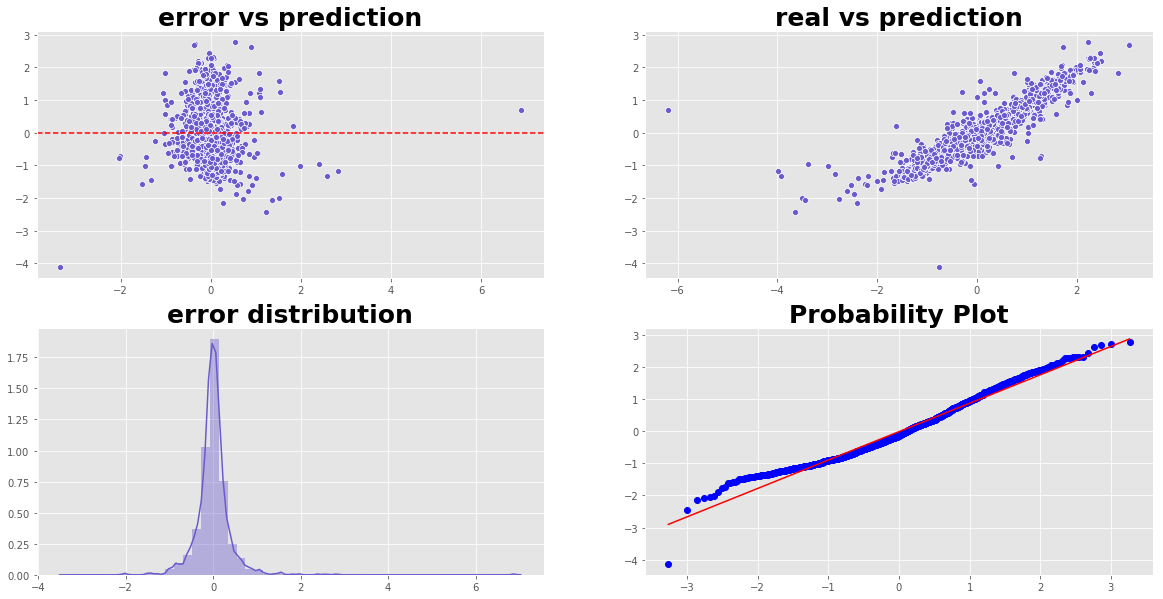

In [19]:
#Random Forest Regressor 
regression_visualizers(get_model='RandomForestRegressor_gridsearch', get_folder='p4_00_energy_models/')

In [20]:
energy_rfr_model = pickle.load(open('p4_00_energy_models/RandomForestRegressor_gridsearch.pkl', 'rb'))
pd.Series(energy_rfr_model.feature_importances_*100, index=X_train.columns).nlargest(20)

PropertyGFATotal                 67.261458
YearBuilt                         6.000162
Longitude                         5.733221
Latitude                          5.239361
x0_Multifamily Housing            3.281412
x0_Non-Refrigerated Warehouse     2.178511
NumberofFloors                    2.023985
x0_Distribution Center            0.849948
CouncilDistrictCode               0.717666
x2_NonResidential                 0.629435
x3_MAGNOLIA / QUEEN ANNE          0.490798
x3_GREATER DUWAMISH               0.425864
x1_Mixed Use Property             0.371326
x0_Office                         0.370839
x2_Nonresidential COS             0.331149
x0_Worship Facility               0.324308
x3_DOWNTOWN                       0.304530
x1_Worship Facility               0.250270
NumberofBuildings                 0.227446
x3_EAST                           0.209211
dtype: float64

## Recherche de modèles de prédiction pour les émissions de CO2
L'objectif est de pouvoir prédire les émissions de CO2 de bâtiments pour lesquels elles n’ont pas encore été mesurées.

In [21]:
X_train, X_test, y_train, y_test = data_preprocessing(data=sample, target='TotalGHGEmissions_trans', 
                                   exclude=['TotalGHGEmissions_trans', 'SiteEnergyUse(kBtu)_trans',
                                            'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore']
                                            ,test_size=0.2)

In [22]:
compar_results_emissions = regressor_compar(data=sample, models=mymodels, grids=mygrids, 
                                            foldername='p4_00_emissions_models/')
compar_results_emissions

Comparative table of models…


,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
Standard Time,0.00579596,2.09872,2.4141,2.96731,3.52457,16.5881,73.0243,171.013
GridSearch Time,1.96739,2.30933,2.69027,3.24176,11.6801,46.6119,116.062,273.239
RandomSearch Time,2.0918,2.40588,2.96128,3.48797,14.5816,69.6739,169.779,559.525
Standard R²,0.436805,0.436975,-0.000781605,-0.000781605,0.394081,0.565222,0.816049,0.623747
GridSearch R²,0.436805,0.436975,0.434267,0.436136,0.406709,0.565222,0.819213,0.758478
RandomSearch R²,0.436805,0.436975,0.434267,0.436136,0.406709,0.559876,0.819213,0.758478
Standard RMSE,0.751999,0.751886,1.00244,1.00244,0.780001,0.660727,0.429773,0.614651
GridSearch RMSE,0.751999,0.751886,0.753692,0.752446,0.771831,0.660727,0.426061,0.492454
RandomSearch RMSE,0.751999,0.751886,0.753692,0.752446,0.771831,0.664776,0.426061,0.492454


In [23]:
compar_results_emissions[compar_results_emissions.index.str.contains('Grid')]

,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
GridSearch Time,1.96739,2.30933,2.69027,3.24176,11.6801,46.6119,116.062,273.239
GridSearch R²,0.436805,0.436975,0.434267,0.436136,0.406709,0.565222,0.819213,0.758478
GridSearch RMSE,0.751999,0.751886,0.753692,0.752446,0.771831,0.660727,0.426061,0.492454


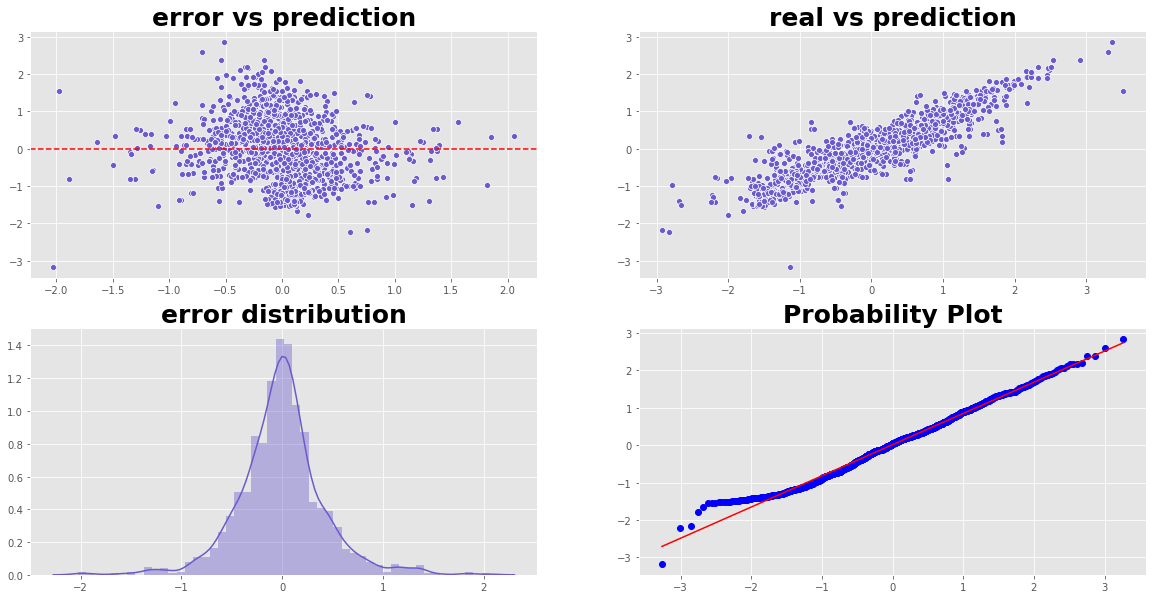

In [24]:
regression_visualizers(get_model='RandomForestRegressor_gridsearch', get_folder='p4_00_emissions_models/')

In [25]:
carbon_rfr_model = pickle.load(open('p4_00_emissions_models/RandomForestRegressor_gridsearch.pkl', 'rb'))
pd.Series(carbon_rfr_model.feature_importances_*100, index=X_train.columns).nlargest(20)

PropertyGFATotal                 47.084799
YearBuilt                        14.406709
Longitude                         8.002508
Latitude                          7.948130
x1_Low-Rise Multifamily           6.334390
NumberofFloors                    3.082281
x0_Non-Refrigerated Warehouse     1.398868
CouncilDistrictCode               1.041052
x0_Multifamily Housing            0.994943
x0_Office                         0.823064
x2_NonResidential                 0.688978
x1_Mid-Rise Multifamily           0.652538
x3_EAST                           0.520964
x3_MAGNOLIA / QUEEN ANNE          0.487251
x3_DOWNTOWN                       0.458546
x3_GREATER DUWAMISH               0.450774
x3_LAKE UNION                     0.409920
NumberofBuildings                 0.359651
x0_Distribution Center            0.359477
x2_Multifamily MR (5-9)           0.327475
dtype: float64

## Evaluation de l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions de CO2
Ajout d'une variable 'ENERGYSTARScore' afin d'évaluer l'importance ou non de l'indicateur dans la prévision en émissions de carbone.

In [27]:
X_train, X_test, y_train, y_test = data_preprocessing(data=sample, target='TotalGHGEmissions_trans', 
                            exclude=['TotalGHGEmissions_trans', 'SiteEnergyUse(kBtu)_trans',
                                     'TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], test_size=0.2)

display(X_train.shape)
display(X_test.shape)

(5040, 47)

(1260, 47)

In [28]:
compar_results_emissions_energystar = regressor_compar(data=sample, models=mymodels, grids=mygrids, 
                                                       foldername='p4_00_emissions_energystar_models/')
compar_results_emissions_energystar

Comparative table of models…


,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
Standard Time,0.00583601,1.95048,2.26186,2.7754,3.23863,18.3043,64.6671,167.426
GridSearch Time,1.82868,2.16754,2.54046,2.95865,12.8008,47.0794,110.438,180.138
RandomSearch Time,1.945,2.25499,2.76879,3.19896,16.1292,61.575,166.118,227.061
Standard R²,0.45975,0.459824,-6.5749e-05,-6.5749e-05,0.4464,0.614614,0.779342,0.659135
GridSearch R²,0.45975,0.45975,0.455794,0.457659,0.460981,0.614614,0.779918,0.553939
RandomSearch R²,0.45975,0.459752,0.455794,0.457659,0.459942,0.528108,0.779918,0.553939
Standard RMSE,0.734302,0.734252,0.99906,0.99906,0.743319,0.620191,0.469285,0.583269
GridSearch RMSE,0.734302,0.734302,0.736985,0.735722,0.733465,0.620191,0.468673,0.667229
RandomSearch RMSE,0.734302,0.734301,0.736985,0.735722,0.734171,0.686276,0.468673,0.667229


In [29]:
compar_results_emissions_energystar[compar_results_emissions_energystar.index.str.contains('Grid')]

,lr,ridge,lasso,elastic,knn,svr,rfr,gradboost
GridSearch Time,1.82868,2.16754,2.54046,2.95865,12.8008,47.0794,110.438,180.138
GridSearch R²,0.45975,0.45975,0.455794,0.457659,0.460981,0.614614,0.779918,0.553939
GridSearch RMSE,0.734302,0.734302,0.736985,0.735722,0.733465,0.620191,0.468673,0.667229


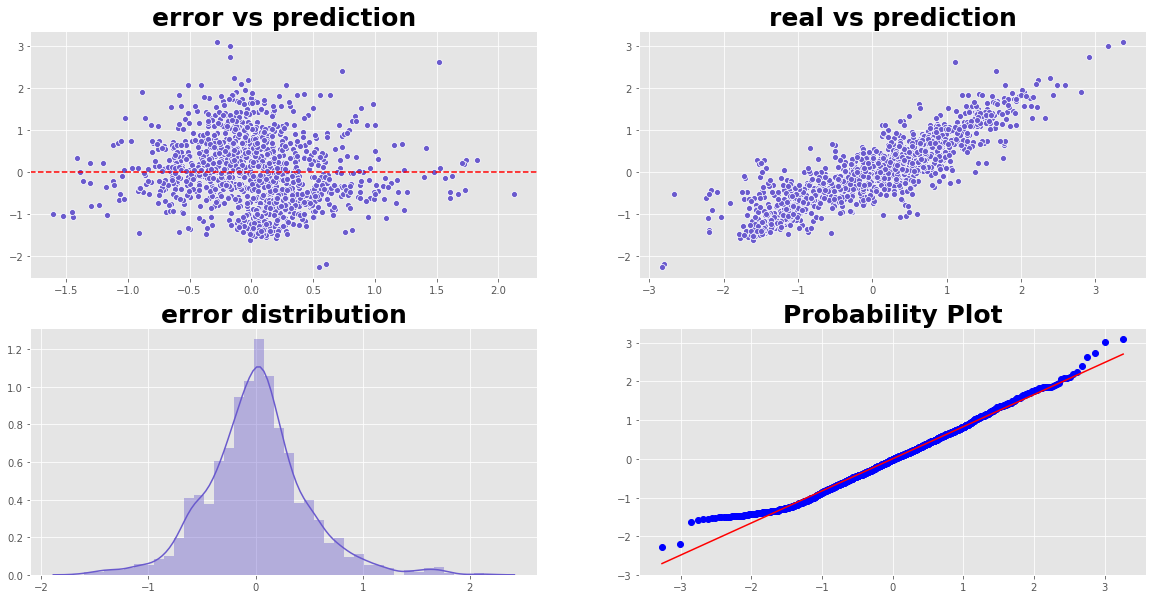

In [30]:
regression_visualizers(get_model='RandomForestRegressor_gridsearch', 
                       get_folder='p4_00_emissions_energystar_models/')

In [31]:
carbon_energystar_rfr_model = pickle.load(open('p4_00_emissions_energystar_models/RandomForestRegressor_gridsearch.pkl', 'rb'))
pd.Series(carbon_energystar_rfr_model.feature_importances_*100, index=X_train.columns).nlargest(20)

PropertyGFATotal                 44.842287
YearBuilt                        11.983952
ENERGYSTARScore                  11.723887
x1_Low-Rise Multifamily           6.783007
Longitude                         5.697185
Latitude                          5.263377
NumberofFloors                    2.759693
x0_Non-Refrigerated Warehouse     1.383397
CouncilDistrictCode               0.871504
x0_Multifamily Housing            0.632013
x0_Office                         0.549836
x3_GREATER DUWAMISH               0.481835
x2_NonResidential                 0.459639
x0_Distribution Center            0.371540
x3_EAST                           0.367771
x3_LAKE UNION                     0.359665
x3_MAGNOLIA / QUEEN ANNE          0.319880
x3_DOWNTOWN                       0.304068
x1_Mixed Use Property             0.293380
x0_Hotel                          0.284259
dtype: float64

## Conclusion et axes possibles d'amélioration

Dans le contexte métier lié aux performances énergétiques des bâtiments de la ville de Seattle, il est clairement identifiés qu'un algorithme ensembliste sera plus adapté et plus performant qu'une simple approche prédictive.

Ici, nous avons pu démontrer **les performances d'un meta-algorithme d'apprentissage ensembliste, le Random Forest ajusté par validation croisée**. On a pu améliorer la stabilité et la précision, aucun risque de surapprentissage dans le protocole proposé.

**Ce modèle d'apprentissage supervisé est adapté au problème métier**, il permettrait donc de se passer des relevés de consommation annuels, donc diminution des coûts, des tâches fastidieuses, fuites de données, etc…

Pour finir sur la question de l’intérêt de **l’"ENERGY STAR Score"** pour la prédiction d’émissions de CO2, il a été démontré que les performances sont plus médiocres avec la prise en compte de l'indicateur. **Dans ce contexte d'analyse, l'indicateur n'est pas utile à la prédiction d'émissions de carbone.**


### Axes possibles d'amélioration 
Un échantillon de départ dont les variables sont assez importantes, mais les caractéristiques techniques véritablement utiles à l'étude de la problématique, pourraient être enrichis. Par exemple, par l'ajout de caractéritiques propres aux isolants thermiques des bâtiments, le type d'éclairage, ou encore des indications météorologiques. 